# Voorspellen gebruik van gas

## 1. Importen packages en dataframe

### 1.1 Packages

In [197]:
import pandas as pd
import numpy as np
import datetime as dt
import plotnine as p9
import matplotlib.pyplot as plt
#from plotnine import *
#from plotnine.data import *

%matplotlib inline

### 1.2 Ophalen data van Raspberry PI

In [340]:
df = pd.read_csv('//raspberrypi/pi/domoticz/data/logging.csv')
df.columns = df.columns.str.lower()
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%d-%m-%Y %H:%M:%S")
df['datum'] = pd.to_datetime(df['timestamp'].dt.date)

df = (
    df[['timestamp', 'datum',
         'dagverbruik_gas',
         'kamertemperatuur',
         'thermostaat',
         'buitentemperatuur']]
    .rename(columns={'datum': 'date',
                     'dagverbruik_gas': 'usage',
                     'kamertemperatuur': 'temp_room',
                     'thermostaat': 'temp_setting',
                     'buitentemperatuur': 'temp_out'})
    .dropna(subset=['usage'])
)

df.head(5)

timestamp       date  usage  temp_room  temp_setting  temp_out
1586 2019-02-16 2019-02-16  4.237       19.7          15.0       5.7
3026 2019-02-17 2019-02-17  6.753       20.0          15.0       4.5
4464 2019-02-18 2019-02-18  4.326       19.7          15.0       6.0
5904 2019-02-19 2019-02-19  5.517       19.8          15.0       7.9
7344 2019-02-20 2019-02-20  6.390       19.5          15.0       6.8

### 1.3 Definitions

In [137]:
def plot_line(x,y,title,color):
    return(
        p9.ggplot() + 
        p9.geom_line(data=df, 
                     mapping=p9.aes(x=x,
                                    y=y),
                     color=color) + 
        p9.labs(title=title) +
        p9.theme(figure_size=(8, 3),
                 plot_title=element_text(weight='bold', size = 11),
                 axis_title_x=element_text(weight='bold', size=9),
                 axis_title_y=element_text(weight='bold', size=9),
                 axis_text_x=element_text(angle=45, size=7),
                 axis_text_y=element_text(size=7)
                )
    )

In [382]:
def usage_mean(df):
    usage_mean=df['usage'].mean()
    return usage_mean
 
def usage_max(df):
    usage_ax=df['usage'].max()
    return usage_max

def usage_min(df):
    usage_min=df['usage'].min()
    return usage_min

# 2 Eerste inzichten

### 2.1 Gasverbruik per dag

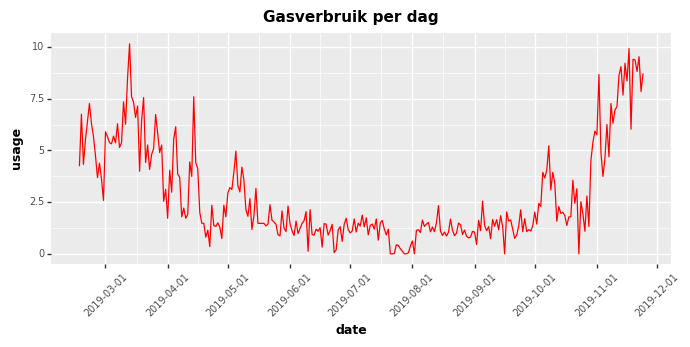

<ggplot: (-9223371907209747764)>

In [138]:
plot_line('date', 'usage', "Gasverbruik per dag", 'red')

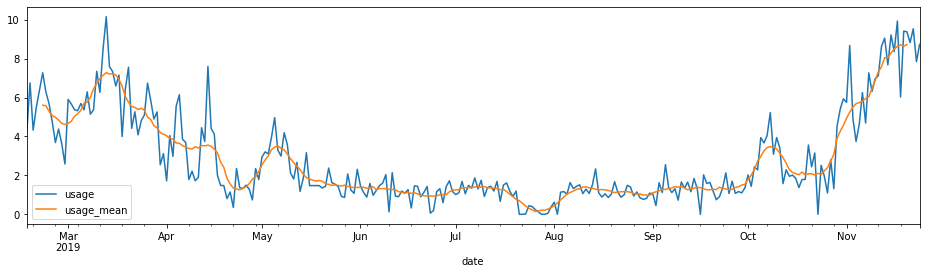

In [282]:
(
    df[['date', 'usage']]
    .set_index('date')
    .assign(usage_mean=lambda d: (d['usage']#.rolling("10D").mean())
                                  .rolling(10, center=True, win_type="gaussian")
                                  .mean(std=5)))
    .plot(figsize=(16, 4))
)


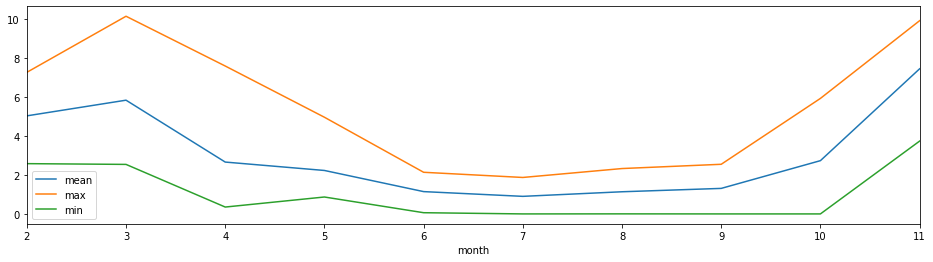

In [348]:
mean=(
    df
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"mean": np.mean(d['usage'])}))
)

maximum=(
    df
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"max": np.max(d['usage'])}))
)

minimal=(
    df
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"min": np.min(d['usage'])}))
)

(
   mean
    .join(maximum)
    .join(minimal)
    .plot(figsize=(16, 4))
)

del mean
del maximum
del minimal

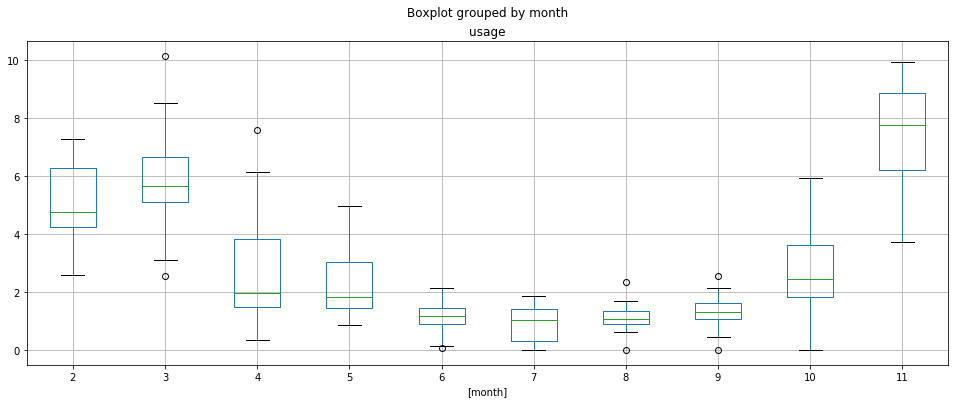

In [335]:
(
    df[['date', 'usage']]
    .assign(month=lambda d: d['date'].dt.month)
    .drop(['date'], axis=1)
    .boxplot(by=['month'], figsize=(16,6))
)

In [410]:
df_min=(
    df[['date','usage']]
    .loc[lambda d: d['usage'] > 0.5]
)
   
usage_summer = usage_min(df_min)
usage_summer

0.6

In [411]:
df_test=(
    df
    .copy()
    .assign(usage_het = lambda d: d['usage'] - usage_summer)
    .loc[lambda d: d['usage'] >= 0]
)

In [412]:
df_test

timestamp       date  usage  temp_room  temp_setting  \
1586   2019-02-16 00:00:00 2019-02-16  4.237       19.7          15.0   
3026   2019-02-17 00:00:00 2019-02-17  6.753       20.0          15.0   
4464   2019-02-18 00:00:00 2019-02-18  4.326       19.7          15.0   
5904   2019-02-19 00:00:00 2019-02-19  5.517       19.8          15.0   
7344   2019-02-20 00:00:00 2019-02-20  6.390       19.5          15.0   
...                    ...        ...    ...        ...           ...   
400002 2019-11-20 00:00:00 2019-11-20  9.378       19.6          15.0   
401442 2019-11-21 00:00:00 2019-11-21  8.821       19.6          15.0   
402878 2019-11-22 00:00:03 2019-11-22  9.533       19.5          15.0   
404318 2019-11-23 00:00:00 2019-11-23  7.848       20.5          15.0   
405758 2019-11-24 00:00:00 2019-11-24  8.730       20.1          15.0   

        temp_out  usage_het  
1586         5.7      3.637  
3026         4.5      6.153  
4464         6.0      3.726  
5904         7.9      4.917  
7344         6.8      5.790  
...          ...        ...  
400002       1.7      8.778  
401442       2.5      8.221  
402878       2.5      8.933  
404318       4.9      7.248  
405758       4.9      8.130  

[282 rows x 7 columns]